In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import keras_tuner as kt
import numpy as np

import kaggle_functions as kaggle
import importlib
importlib.reload(kaggle);

In [2]:
train_dataset, test_dataset= kaggle.load_train_as_dataset()
x_test_real = kaggle.load_test_set()
_, _, _, _, _, test_true = kaggle.load_train_set()

### GoogLeNet

In [33]:
class GoogLeNetHyperModel(kt.HyperModel):
    def inception_layer(self, input, f1, f3_in, f3_out, f5_in, f5_out, pool_out, dropout=0):
        conv1 = layers.Conv2D(
            f1, kernel_size=(1,1), padding='same', 
            activation='relu', kernel_initializer=keras.initializers.HeNormal())(input)
        
        conv3 = layers.Conv2D(
            f3_in, (1,1), padding='same', 
            activation='relu', kernel_initializer=keras.initializers.HeNormal())(input)
        conv3 = layers.Conv2D(
            f3_out, kernel_size=(3,3), padding='same', 
            activation='relu', kernel_initializer=keras.initializers.HeNormal())(conv3)
        
        conv5 = layers.Conv2D(
            f5_in, (1,1), padding='same', 
            activation='relu', kernel_initializer=keras.initializers.HeNormal())(input)
        conv5 = layers.Conv2D(
            f5_out, kernel_size=(5,5), padding='same', 
            activation='relu', kernel_initializer=keras.initializers.HeNormal())(conv5)
        
        pool = layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(input)
        pool = layers.Conv2D(
            pool_out, kernel_size=(1,1), padding='same', 
            activation='relu', kernel_initializer=keras.initializers.HeNormal())(pool)
        
        layer_out = layers.concatenate([conv1, conv3, conv5, pool])

        if dropout == 0:
            return layer_out
        else:
            return layers.Dropout(dropout)(layer_out)
    
    def maxpool_layer(self, input):
        return layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(input)

    def conv_layer(self, input, filter, kernel):
        return layers.Conv2D(
            filters=filter, kernel_size=(kernel,kernel), padding='same',
            kernel_initializer=keras.initializers.HeNormal())(input)

    def dense_layer(self, input, size, l2_reg, dropout):
        dense = layers.Dense(
            size, activation='relu',
            kernel_regularizer=keras.regularizers.l2(l2_reg))(input)
        return layers.Dropout(dropout)(dense)

    def build(self, hyperparameters):
        # Hyperparameters
        if isinstance(hyperparameters, kt.engine.hyperparameters.HyperParameters):
            second_inception_layer = hyperparameters.Boolean('second_inception_layer')
        elif isinstance(hyperparameters, dict): 
            second_inception_layer = hyperparameters['second_inception_layer']
        else: # Default
            second_inception_layer = False

        # Fixed hyperparameters
        l2_reg = 0.005

        spatial_dropout = 0.2
        conv_dropout = 0.15
        dense_dropout = 0.7
        gaussian_noise = 0.01

        input_layer = layers.Input(shape=(96, 96, 1))
        output = layers.GaussianNoise(gaussian_noise)(input_layer)

        # Input convolution
        # Local respnorm and Spatial Dropout added
        output = self.conv_layer(output, 64, 7)
        output = layers.SpatialDropout2D(spatial_dropout)(output)
        output = self.maxpool_layer(output)
        output = tf.nn.local_response_normalization(output)

        # Second input convolution
        output = self.conv_layer(output, 192, 3)
        output = tf.nn.local_response_normalization(output)
        output = layers.SpatialDropout2D(spatial_dropout)(output)
        output = self.maxpool_layer(output)
        output = layers.GaussianNoise(gaussian_noise)(output)

        # Inception layers, level 1
        output = self.inception_layer(output, 64, 96, 128, 16, 32, 32, dropout=conv_dropout) #3a
        output = self.inception_layer(output, 128, 128, 192, 32, 96, 64, dropout=conv_dropout) #3b
        output = self.maxpool_layer(output)

        # Inception layers, level 2
        output = self.inception_layer(output, 192, 96, 208, 16, 48, 64, dropout=conv_dropout) #4a
        if second_inception_layer:
            output = self.inception_layer(output, 160, 112, 224, 24, 64, 64, dropout=conv_dropout) #4b
            output = self.inception_layer(output, 128, 128, 256, 24, 64, 64, dropout=conv_dropout) #4c
            output = self.inception_layer(output, 96, 144, 288, 32, 64, 64, dropout=conv_dropout) #4d

        # Auxilliary prediction layer
        output = layers.AveragePooling2D(pool_size=(5,5), strides=(2,2))(output)
        output = self.conv_layer(output, 128, 1)
        output = layers.Flatten()(output)
        output = self.dense_layer(output, 512, l2_reg=l2_reg, dropout=dense_dropout)

        # Final output
        output = keras.layers.Dense(11)(output)

        model = keras.models.Model(inputs=input_layer, outputs=output)

        # Create model
        model.compile(
            optimizer=keras.optimizers.Nadam(0.0001),
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

        return model

# GoogLeNetHyperModel().build(None).summary()

In [ ]:
# Hyperparameter tuning
# 12 trials at 14 max epoch took 6 hours

reload_tuner = True
tuner_filepath = 'hypertuner_2021-11-24'

tuner_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
]

tuner = kt.BayesianOptimization(GoogLeNetHyperModel(),
    objective='val_accuracy',
    max_trials=2,
    seed=1,
    directory='models/model3',
    project_name=tuner_filepath,
    overwrite=(not reload_tuner))

tuner.search_space_summary()

if reload_tuner:
    tuner.reload()
else:
    tuner.search(
        train_dataset.batch(64).cache(), 
        validation_data=test_dataset.batch(64).cache(),
        epochs=14, callbacks=tuner_callbacks, verbose=1)

tuner.results_summary()

best_hyperparameters = tuner.get_best_hyperparameters()[0]
best_model = tuner.get_best_models()[0]
best_model.save(f'models/model3/{tuner_filepath}/saved_model')

In [ ]:
# Load existing model if wanted, otherwise create new
use_existing_model = False
model_filepath = 'models/model3/googlenet_3'
if use_existing_model:
    print("Loading existing model")
    model = keras.models.load_model(model_filepath)
else:
    print("Creating new model")
    model = GoogLeNetHyperModel().build({'second_inception_layer': False})

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
]

# Fit model (can continue from loaded weights)
history1 = model.fit(
    train_dataset.batch(64).cache(), 
    validation_data=test_dataset.batch(64).cache(),
    epochs=70, callbacks=callbacks, verbose=1)

# Save model
model.save(model_filepath)

kaggle.plot_model_history(history1, ['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
# Load existing model if wanted, otherwise create new
use_existing_model = False
model_filepath = 'models/model3/googlenet_4'
if use_existing_model:
    print("Loading existing model")
    model = keras.models.load_model(model_filepath)
else:
    print("Creating new model")
    model = GoogLeNetHyperModel().build({'second_inception_layer': True})
    
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
]

# Fit model (can continue from loaded weights)
history2 = model.fit(
    train_dataset.batch(64).cache(), 
    validation_data=test_dataset.batch(64).cache(),
    epochs=90, callbacks=callbacks, verbose=1)

# Save model
model.save(model_filepath)
kaggle.plot_model_history(history2, ['accuracy', 'loss', 'val_accuracy', 'val_loss'])

### Evaluate model

Accuracy: 0.6682


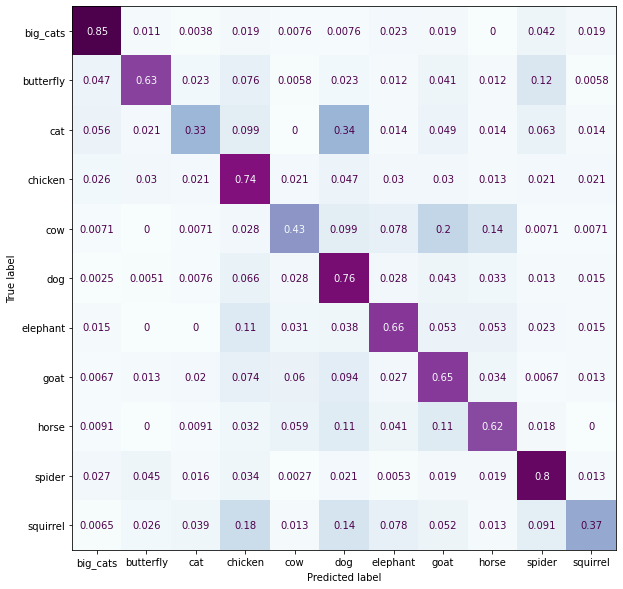

In [ ]:
test_pred_raw = model.predict(test_dataset.batch(128))
test_pred = np.argmax(test_pred_raw, axis=1)

kaggle.print_accuracy(test_pred, test_true)
kaggle.plot_confusion_matrix(test_true, test_pred)

### Get labels for Kaggle

In [ ]:
true_test_pred = np.argmax(model.predict(x_test_real), axis=1)

kaggle.save_test_pred('models\model3\saved_model_2_pred.csv', true_test_pred)